[View in Colaboratory](https://colab.research.google.com/github/Janderson/python-trade/blob/master/Markowitz.ipynb)

In [0]:
#@title Default title text
#!pip install pandas_datareader
#!pip install cvxopt
#!pip install fix_yahoo_finance

In [0]:
#@title Default title text
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr

import cvxopt as opt
from cvxopt import solvers
from pandas_datareader import data as pdr

import fix_yahoo_finance as yf
yf.pdr_override() # <== that's all it takes :-)


def create_random_weights(n_assets):
    '''
    returns randomly choosen portfolio weights that sum to one
    '''
    w = np.random.rand(n_assets)
    return w / w.sum()
 
def evaluate_random_portfolio(returns):
    ''' 
    returns the mean and standard deviation of returns for a random portfolio
    '''
    # in case a resampler is used
    returns = pd.DataFrame(returns)   
    
    # calculate from covariance, asset returns and weights
    cov = np.matrix(returns.cov())
    R = np.matrix(returns.mean())
    w = np.matrix(create_random_weights(returns.shape[1]))
    
    # calculate expected portfolio return and risk
    mu = w * R.T
    sigma = np.sqrt(w * cov * w.T)
    
    return mu, sigma
 
def create_random_portfolios(returns, n_portfolios=1500):
    '''
    plots randomly created portfolios
    '''
    # calculate mean and std for every portfolio
    pf_mus, pf_sigmas = np.column_stack([evaluate_random_portfolio(returns) for _ in range(n_portfolios)])
 
    return pf_mus, pf_sigmas


 
def calculate_frontier(returns):
    '''
    returns optimal portfolio weights and corresponding sigmas for a desired optimal portfolio return
    Params:
    - returns: T x N matrix of observed data
    '''
    returns = pd.DataFrame(returns)
    cov = np.matrix(np.cov(returns.T))
    N = returns.shape[1]
    pbar = np.matrix(returns.mean())
    
    # define list of optimal / desired mus for which we'd like to find the optimal sigmas
    optimal_mus = []
    r_min = pbar.mean()    # minimum expected return
    for i in range(50):
        optimal_mus.append(r_min)
        r_min += (pbar.mean() / 100)
    
    # constraint matrices for quadratic programming
    P = opt.matrix(cov)
    q = opt.matrix(np.zeros((N, 1)))
    G = opt.matrix(np.concatenate((-np.array(pbar), -np.identity(N)), 0))
    A = opt.matrix(1.0, (1,N))
    b = opt.matrix(1.0)
    
    # hide optimization
    opt.solvers.options['show_progress'] = False
    
    # calculate portfolio weights, every weight vector is of size Nx1
    # find optimal weights with qp(P, q, G, h, A, b)
    optimal_weights = [solvers.qp(P, q, G, opt.matrix(np.concatenate((-np.ones((1, 1)) * mu, np.zeros((N, 1))), 0)), A, b)['x'] for mu in optimal_mus]
    
    # find optimal sigma
    # \sigma = w^T * Cov * w
    optimal_sigmas = [np.sqrt(np.matrix(w).T * cov.T.dot(np.matrix(w)))[0,0] for w in optimal_weights]
    
    return optimal_weights, optimal_mus, optimal_sigmas

In [40]:
np.random.seed(1)
 
# length of artificial time series
n_obs = 1000
 
# number of different assets
n_assets = 4
 
# sample Nx4 data series matrix
artificial_returns = np.random.randn(n_obs, n_assets) + 0.05
artificial_returns.shape

(1000, 4)

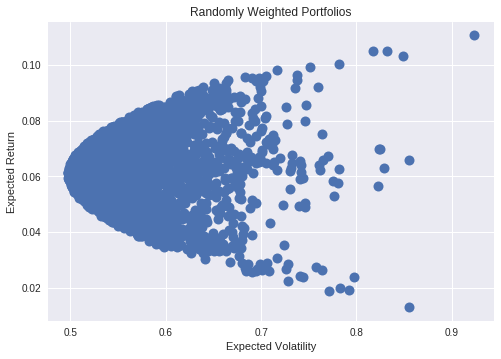

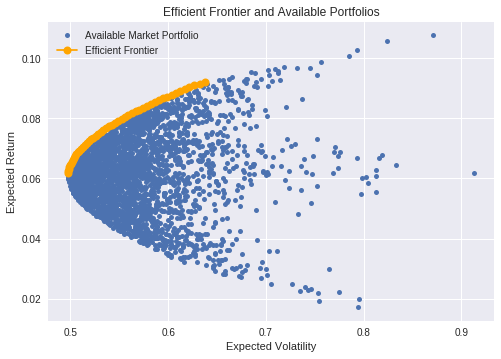

In [15]:
# calculate mus and sigmas for all and the optimal portfolios
pf_mus, pf_sigmas = create_random_portfolios(artificial_returns, n_portfolios=3000)
optimal_weights, optimal_mus, optimal_sigmas = calculate_frontier(artificial_returns)
 
plt.plot(pf_sigmas, pf_mus, 'o', markersize=5, label='Available Market Portfolio')
plt.plot(optimal_sigmas, optimal_mus, 'y-o', color='orange', markersize=8, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Available Portfolios')
plt.legend(loc='best')
plt.show()

In [16]:
	
# example of optimal weight#
print(optimal_weights[30])

[ 2.32e-01]
[ 8.72e-02]
[ 2.62e-01]
[ 4.19e-01]



[*********************100%***********************]  5 of 5 downloaded


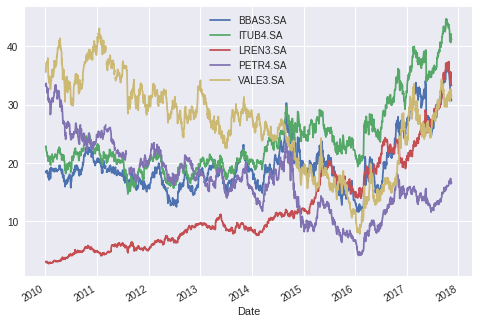

In [58]:
tickers = ["VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBAS3.SA", "LREN3.SA"]
start = '2010-01-01'
end = '2017-11-14'

# download dataframe
data = pdr.get_data_yahoo(tickers, start=start, end=end)['Adj Close']


data.plot();



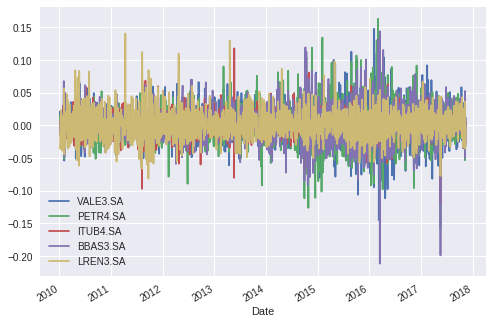

In [59]:
returns = data[tickers] / data[tickers].shift(1) - 1
returns = returns.fillna(method='ffill').dropna()

returns.plot()

In [60]:
pf_mus, pf_sigmas = create_random_portfolios(returns.values, n_portfolios=3000)

pf_sigmas

array([[0.01878953],
       [0.01748198],
       [0.01835213],
       ...,
       [0.01968399],
       [0.01826276],
       [0.01789636]])

In [0]:
optimal_weights, optimal_mus, optimal_sigmas = calculate_frontier(returns.values)

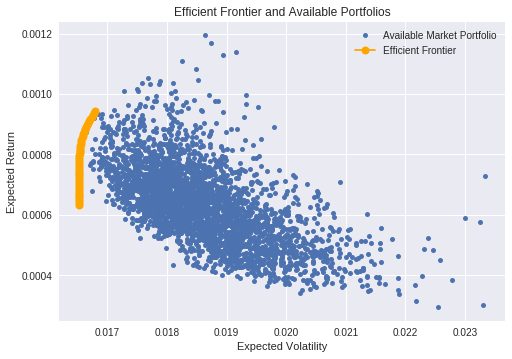

In [62]:
pf_mus, pf_sigmas = create_random_portfolios(returns, n_portfolios=3000)
optimal_weights, optimal_mus, optimal_sigmas = calculate_frontier(returns)
 
plt.plot(pf_sigmas, pf_mus, 'o', markersize=5, label='Available Market Portfolio')
plt.plot(optimal_sigmas, optimal_mus, 'y-o', color='orange', markersize=8, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Available Portfolios')
plt.legend(loc='best')
plt.show()

In [64]:
	
# example of optimal weight#
print(optimal_weights[30])

[ 1.75e-01]
[ 3.44e-03]
[ 4.58e-01]
[ 1.74e-03]
[ 3.62e-01]



source:

http://dacatay.com/data-science/portfolio-optimization-python/
